# Render input and output data

This notebook produces images for the thesis.

In [1]:
import sys

import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.initializers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K
from keras.regularizers import l2
from keras.engine.topology import Layer
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random
import gc

from modelServer.models.LineFilterLayer import LineFilterLayer
from modelServer.models.ValueLayer import ValueLayer

Using TensorFlow backend.


In [19]:
def dotsAndBoxesToCategorical(inputData):
    inp = np.copy(inputData)
    inp[inp == 255] = 1 # Line - comes first so that target data only has two categories
    inp[inp == 65] = 2 # Box A
    inp[inp == 150] = 3 # Box B
    inp[inp == 215] = 4 # Dot
    cat = to_categorical(inp)
    newShape = inp.shape + (cat.shape[-1],)
    return cat.reshape(newShape)

def imgSizeToBoxes(x):
    return (x-3)/2

def lineFilterMatrixNP(imgWidth,imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = 1
    return mat

def loadPVDataset(datasetPath):
    rawDataset = np.load(datasetPath)
    
    x_input = rawDataset['input']
    y_policy = rawDataset['policy']
    y_value = rawDataset['value']
    
    x_input = dotsAndBoxesToCategorical(x_input)
    y_policy = y_policy[:,lineFilterMatrixNP(y_policy.shape[-1], y_policy.shape[-2])]
    y_policy /= 255
    
    return (x_input, y_policy, y_value)

def linesToDotsAndBoxesImage(lines, imgWidth, imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=lines.dtype)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = lines[idx]
    return mat

def createImage(data):
    # merge image data in color channels
    merged_imgdata = np.stack([data, data, data], axis=2)
    #create image
    img = Image.fromarray(merged_imgdata, 'RGB')
    img = img.resize(size=(img.size[0]*10, img.size[1]*10))
    return img

## StageOne data

x_train[0]:
[[  0   0   0   0   0   0   0   0   0]
 [  0 215 255 215 255 215 255 215   0]
 [  0 255  65 255  65 255  65 255   0]
 [  0 215 255 215 255 215 255 215   0]
 [  0   0   0 255  65 255  65 255   0]
 [  0 215 255 215 255 215 255 215   0]
 [  0 255 150 255   0   0   0 255   0]
 [  0 215 255 215 255 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0]]
y_train[0]:
[[  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0 255   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]


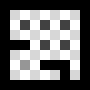

In [21]:
firstTryDataset = np.load('StageOne-3x3.npz')
x_train = firstTryDataset['x_train']
y_train = firstTryDataset['y_train']

print("x_train[0]:")
print(x_train[0])
print("y_train[0]:")
print(y_train[0])

createImage(x_train[0])

## Categorical input data (planes)

In [22]:
x_train_cat = dotsAndBoxesToCategorical(x_train)
x_train_cat.shape

(8, 9, 9, 5)

[[255 255 255 255 255 255 255 255 255]
 [255   0   0   0   0   0   0   0 255]
 [255   0   0   0   0   0   0   0 255]
 [255   0   0   0   0   0   0   0 255]
 [255 255 255   0   0   0   0   0 255]
 [255   0   0   0   0   0   0   0 255]
 [255   0   0   0 255 255 255   0 255]
 [255   0   0   0   0   0 255   0 255]
 [255 255 255 255 255 255 255 255 255]]


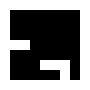

In [30]:
plane = 0
print(x_train_cat[0,::,::,plane].astype(np.uint8)*255)
createImage(x_train_cat[0,::,::,plane].astype(np.uint8)*255)

[[  0   0   0   0   0   0   0   0   0]
 [  0   0 255   0 255   0 255   0   0]
 [  0 255   0 255   0 255   0 255   0]
 [  0   0 255   0 255   0 255   0   0]
 [  0   0   0 255   0 255   0 255   0]
 [  0   0 255   0 255   0 255   0   0]
 [  0 255   0 255   0   0   0 255   0]
 [  0   0 255   0 255   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]


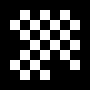

In [31]:
plane = 1
print(x_train_cat[0,::,::,plane].astype(np.uint8)*255)
createImage(x_train_cat[0,::,::,plane].astype(np.uint8)*255)

[[  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0 255   0 255   0 255   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 255   0 255   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]


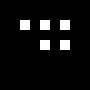

In [32]:
plane = 2
print(x_train_cat[0,::,::,plane].astype(np.uint8)*255)
createImage(x_train_cat[0,::,::,plane].astype(np.uint8)*255)

[[  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0 255   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]


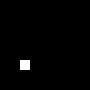

In [33]:
plane = 3
print(x_train_cat[0,::,::,plane].astype(np.uint8)*255)
createImage(x_train_cat[0,::,::,plane].astype(np.uint8)*255)

[[  0   0   0   0   0   0   0   0   0]
 [  0 255   0 255   0 255   0 255   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0 255   0 255   0 255   0 255   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0 255   0 255   0 255   0 255   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0 255   0 255   0 255   0 255   0]
 [  0   0   0   0   0   0   0   0   0]]


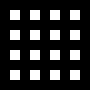

In [34]:
plane = 4
print(x_train_cat[0,::,::,plane].astype(np.uint8)*255)
createImage(x_train_cat[0,::,::,plane].astype(np.uint8)*255)